In [1]:
import time
from picamera2 import Picamera2, Preview
from picamera2.controls import Controls
import cv2
import numpy as np
import matplotlib.pyplot as plt
import RPi.GPIO as GPIO
from time import sleep
import tifffile

In [2]:
led = 23
GPIO.setmode(GPIO.BCM)
GPIO.setup(led, GPIO.OUT)

picam2 = Picamera2()

# Set camera controls
controls = {"ExposureTime": 3000000, #microseconds
            "AnalogueGain":1.0, # 1 = ISO 100
            "AeEnable": False, # Auto exposure and Gain
            "AwbEnable": False,# Auto white Balance
            "FrameDurationLimits": (114,239000000)} #Min/Max frame duration

# Setup config parameters
preview_config = picam2.create_preview_configuration(raw={"size": picam2.sensor_resolution, "format": "SBGGR12",},
                                                     controls = controls) 
print(preview_config)

{'use_case': 'preview', 'transform': <libcamera.Transform 'identity'>, 'colour_space': <libcamera.ColorSpace 'sYCC'>, 'buffer_count': 4, 'queue': True, 'main': {'format': 'XBGR8888', 'size': (640, 480)}, 'lores': None, 'raw': {'format': 'SBGGR12', 'size': (4056, 3040)}, 'controls': {'NoiseReductionMode': <NoiseReductionModeEnum.Minimal: 3>, 'FrameDurationLimits': (114, 239000000), 'ExposureTime': 3000000, 'AnalogueGain': 1.0, 'AeEnable': False, 'AwbEnable': False}, 'display': 'main', 'encode': 'main'}


/tmp/ipykernel_3587/1428768555.py:3: RuntimeWarning: This channel is already in use, continuing anyway.  Use GPIO.setwarnings(False) to disable warnings.
  GPIO.setup(led, GPIO.OUT)
[6:14:44.657945257] [3587]  INFO Camera camera_manager.cpp:299 libcamera v0.0.4+22-923f5d70
[6:14:44.731011636] [3617]  INFO RPI raspberrypi.cpp:1476 Registered camera /base/soc/i2c0mux/i2c@1/imx477@1a to Unicam device /dev/media4 and ISP device /dev/media1


[7:24:34.600178582] [3587]  INFO Camera camera.cpp:1028 configuring streams: (0) 640x480-XBGR8888 (1) 4056x3040-SBGGR12
[7:24:34.618291100] [3617]  INFO RPI raspberrypi.cpp:851 Sensor: /base/soc/i2c0mux/i2c@1/imx477@1a - Selected sensor format: 4056x3040-SBGGR12_1X12 - Selected unicam format: 4056x3040-BG12


{'FocusFoM': 392, 'ExposureTime': 3000000, 'ColourTemperature': 4000, 'SensorTimestamp': 26681400976000, 'ScalerCrop': (2, 0, 4053, 3040), 'SensorBlackLevels': (4096, 4096, 4096, 4096), 'DigitalGain': 1.0, 'ColourGains': (2.510904550552368, 1.656680941581726), 'SensorTemperature': 25.0, 'Lux': 0.10867144167423248, 'FrameDuration': 3000628, 'AeLocked': True, 'ColourCorrectionMatrix': (2.1575498580932617, -1.1039637327194214, -0.05359601974487305, -0.3457588851451874, 1.6122934818267822, -0.2665446400642395, -0.02813815139234066, -0.7009111046791077, 1.7290493249893188), 'AnalogueGain': 1.0}


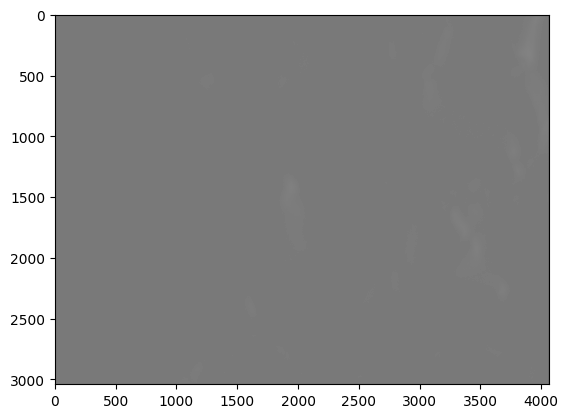

In [16]:

picam2.start_preview(Preview.QTGL)
picam2.configure(preview_config)

GPIO.output(led, GPIO.HIGH) # Turn on LED

picam2.start() # Start Camera
 
time.sleep(2)

#Capture image in unpacked RAW format 12bit dynamic range (16bit array)
raw = picam2.capture_array("raw").view(dtype="uint16")

GPIO.output(led, GPIO.LOW) # Turn off LED

#print(picam2.stream_configuration("raw"))
print(picam2.capture_metadata())

picam2.stop_preview()
picam2.stop()

plt.imshow(raw, cmap="gray")

In [4]:
print(np.shape(raw))
print(np.min(raw))

(3040, 4064)
0


538


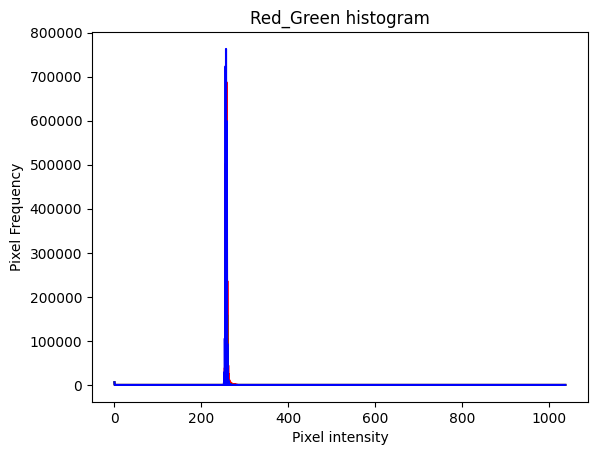

Histogram Succes
257.52829724409446
257.37077127797346
256.62335655822625
Number of red pixels: 3082560
Number of green pixels: 3082560
Number of blue pixels: 3082560


In [17]:
center_crop = raw[1000:2000, 2000:3000]
print(np.max(raw))

#Get color channels in bayer order (BGGR)
red = raw[1::2,1::2]
green1 = raw[0::2,1::2]
green2 = raw[1::2,0::2]
green = np.add(green1,green2)/2
blue = raw[0::2,0::2]

#Make histogram for red and green channel # Set camera controls to have good pixel saturation
Colors=("red","green","blue")
Channel_ids=(red,green,blue)
for channel_id, c in zip(Channel_ids,Colors):
    histogram, bin_edges=np.histogram(channel_id,bins=4095, range=(0,np.max(red)+500))
    plt.plot(bin_edges[0:-1],histogram,color=c)
plt.title("Red_Green histogram")
plt.xlabel("Pixel intensity")
plt.ylabel("Pixel Frequency")
plt.show()
print("Histogram Succes")

print(np.mean(red))
print(np.mean(green))
print(np.mean(blue))

# Count number of red and green pixels
num_red_pixels = np.count_nonzero(red)
num_green_pixels = np.count_nonzero(green)
num_blue_pixels =np.count_nonzero(blue)

print("Number of red pixels:", num_red_pixels)
print("Number of green pixels:", num_green_pixels)
print("Number of blue pixels:", num_blue_pixels)
